# Feature extraction and transfer learning with pre-trained CNNs
Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:* Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.

## Task 1: Downloading images from DuckDuckGo search engine

Our starting point is to find some pictures of objects that we want our neural network to recognize. For that purpose we will be using a Python package that comes with the book ["Deep Learning for Coders"](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). You'll first need to install that package using ``pip`` (in case you get an error message, try running the command again):

In [ ]:
!pip install fastbook --quiet

To get a list of 100 URLs of cat images using the [DuckDuckGo](https://duckduckgo.com/) search engine, run the following code:

In [ ]:
from fastbook import *
urls = search_images_ddg('cat', max_images=100)
print(f'Number of URLs: {len(urls)}')
print(f'First URL {urls[0]}')

Number of URLs: 100
First URL https://c.pxhere.com/photos/9a/56/kitten_cat_feline_yellow_red_portrait_watching_pet-1338723.jpg!s1


To download the image corresponding to the first URL, run this:

In [ ]:
download_url(urls[0], 'cat.jpg')

Path('cat.jpg')

Let's display it also

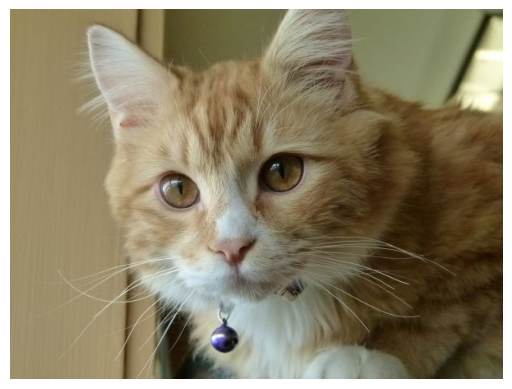

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('cat.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); # Recall OpenCV reads images as BGR
plt.axis('off');

##Task 2: Mount your Google Drive, create data directory, and download training images
Save this notebook to your Google Drive by selecting "Save" or "Save a copy in Drive" in the Files menu. If you want to store data permanently, you also need to mount your Google Drive, which can be done as follows:

**Note:** In my browser, the copy-button that displays next to the authorizatin code doesn't work properly. So I copied the code manually.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create a directory to store the downloaded images in. I prefer to use [pathlab](https://docs.python.org/3/library/pathlib.html), but Google Colab also allows you to run normal shell commands like ``mkdir`` if you prefix the command with ``!`` (see ``ls`` example below).

In [ ]:
from pathlib import Path
root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'data'
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

To check that the data directory was created successfully, you could ``ls`` the parent directory in a shell and and verify that ``data``is there:

In [ ]:
!ls -l "/content/gdrive/My Drive/data"

total 0


Now, lets define the object categories that we are interested in (feel free to modify).

**IMPORTANT**: Class names must appear in alpha-numeric order to be compatible with the class assignment of the image generator below.

In [ ]:
classes = ['cat','dog','horse'] # DuckDuckGo search terms

Then download 100 images from each category (this will take some time). Note that images from each category will be placed in seperate subfolders of the data directory.

**IMPORTANT:** In case the download fails and you have to clear the data directory, uncomment and run these commands (remember to prefix with !):

```
!rm -rf "/content/gdrive/My Drive/data"
!mkdir "/content/gdrive/My Drive/data" # make new empty data directory
````

In [ ]:
# Download images
max_images = 100
count = 0
for idx, category in enumerate(classes):
  print(category)
  folder = category
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  urls = search_images_ddg(category, max_images=max_images)
  download_images(dest,urls=urls,max_pics=max_images)

cat
dog
horse


Verify images (remove files that cannot be opened)

In [ ]:
import cv2
import os
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

cat
Failed to open /content/gdrive/My Drive/data/cat/60e3d657-0adc-4dba-85eb-de4278e948e7.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/cat/167a995b-167f-4f54-90ec-34a9f836c006.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/cat/9c70b2ef-f298-4923-84cf-eb915c4c2cf6.jpg. Deleting file
dog
Failed to open /content/gdrive/My Drive/data/dog/b04855fa-9b4a-4f0f-a699-d5559f3d5a6b.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/dog/56fba160-9755-4a11-a0a6-b9df890a2ac5.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/dog/d45649cd-a94e-4d5c-89f8-f3598293be4c.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/dog/5abd4493-4d69-4902-8371-6ea70a77d44b.jpg. Deleting file
horse
Failed to open /content/gdrive/My Drive/data/horse/60dfd122-c1de-4076-a84f-18560414078d.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data/horse/f1ac74dd-4843-4152-aef9-95bee9b06ec4.jpg. Deleting file
Failed to open /content/gdrive/My Dri

## Task 3: Set up neural network for feature extraction
We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will be covering both of them today. Let's start with feature extraction.

Feature extraction consists of using the representations learned by an existing neural network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. This could be any classifier, such as K-Nearest Neighbours (KNN).

Traditional CNNs are divided into two parts: they start with a series of convolution and pooling layers, and they end with a densely-connected classifier. The first part is often referred to as the "encoder", "feature extractor" or "convolutional base" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output. The second part of the network, called the "decoder" or "top layers", is ignored for now. We will be using it for fine-tuning (Transfer Learning) in Task 10.

First, let's download and instantiate the pre-trained MobileNet without the top layers (i.e., without the decoder).

You can ignore the warning.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

<ipython-input-20-6fb272d3f88a>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(weights='imagenet',


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Let's summarize the model used for feature extraction:

In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 60, 60, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 60, 60, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 60, 60, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 60, 60, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 30, 30, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 30, 30, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 30, 30, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 30, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 30, 30, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 30, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 30, 30, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

That's a lot to digest if you haven't seen a convolutional neural network before. By the end of the course, you will know what it all means. For now, see if you can figure out the answers to these questions:

### Questions 3.1
1. What is the expected shape of the input image?
2. What is the shape of the output of the model?
3. What happens to the output shape if you double the size of the input image?
4. Can you guess what the None dimension is used for?

### Answers
1. The input shape is 120x120x3 and it is set by the variable ```input_shape``` when you define the model.
2. The output shape is 3x3x1024. You can think of it as 3 by 3 image with 1024 channels. For each few layers, the convolutional base makes the representation of the image smaller and smaller in the two spatial dimensions (x/y) and deeper and deeper in the z or channel dimension. The model eventually compresses the input image to a 3x3 grid of 1024-dimensional feature vectors. You can trace each grid cell back to the input image. Dividing the input image into a 3 by 3 grid yields a grid size of 120/3 = 40 pixels. This is referred to as the *receptive view* of the model; it determines how large object parts the model can "see" or "interpret" in the input image.
3. If you increase the input shape, the output shape also increases. It is not always so straight forward to calcualte the exact output shape, but in this case if the input shape is doubled to 240x240x3, the output shape becomes 7x7x1024. So now the input image is compressed to a 7x7 grid of feature vectors. Mapping back to the input image, the receptive field is 240/7 ~ 34 pixels. However, compared to the original image size of 120 x 120 pixels, the receptive field would just be 17 pixels. So the net effect of doubling the size of the input image is to decrease the effective receptive field of the model.
4. It is used if you want to process more images at once. A bunch of images is called a *mini-batch*. There can be many reasons that we want to process the images in mini-batches. For now, the motivation is to avoid having to copy data between the CPU and the GPU all the time. We can load a batch of images onto the GPU, process them there, and copy the results back to the CPU. This is more efficient.

##Task 4: Preprocessing
Many neural networks expect the input image to have a fixed, pre-defined shape. Also, the pixel intensities are assumed to be in a fixed range.

For reasons that will become clear later in the course, neural networks do not work well on images in which the intensities lie in the standard range from 0 to 255. Instead, we want the intensities to be centered around zero. Typical intensity ranges are -127.5 to 127.5 or -1 to 1, but it depends on the chosen neural network architecture. Each pre-trained network in Keras comes with its own *preprocessor*, which assures that the intensities are scaled correctly for that particular network.

In summary, *preprocessing* refers to the step of preparing the image to be fed into the network by making sure the image has the right shape, and that the intensities are in the correct range.

Let's load an image, preprocess it, and feed it through the network:

In [ ]:
import numpy as np
import keras.utils as image
from keras.applications.mobilenet import preprocess_input

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

# Feed preprocessed image through CNN encoder to get a new feature representation
mobilenet_features = conv_base.predict(img_preprocessed)

File path: /content/gdrive/My Drive/data/cat/b2e1c03d-e4b9-44d6-a836-75893862de34.jpg!s1
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### Questions 4.1
1. What is the range of the pixel values before and after preprocessing?
2. So what formula do you think is used to pre-process the pixel values?
3. What is the order of the color channels? (you could compare with ``cv2.imread``, which we know reads images as BGR)
4. What is the size of the input image (``img_data`` after calling ``np.expand_dims``)?
5. What is the size of the calculated feature representation (`mobilenet_features`)?
6. So what is the reduction in dimensionality after feature extraction?

### Answers
See code below answers.

1. It seems that the range before preprocessing is between 0 and 255, which is what you would expect. After preprocessing it seems that the range is between -1 and 1.
2. The formula should convert from range ```0:255``` to range ```-1:1```, so one solution could be ```y = x/127.5 - 1.0```
3. It is RGB. So make sure that you shift the color channels if you load images using OpenCV (which reads images as BGR).
4. It is 1x120x120x3 (the first dimension is the batch size, which is one).
4. It is 1x3x3x1024.
4. You could convert either of these into a feature vector using numpy's flatten(). The dimensionality of the image feature vector is ``120*120*3=43200`` and the dimensionality of the network feature vector is ``3*3*1024=9216``, which gives a reduction in dimensionality of 4 to 5.

np.min(img_data) : 0.0
np.max(img_data) : 255.0
np.min(img_preprocessed) : -1.0
np.max(img_preprocessed) : 1.0
img_preprocessed.shape : (1, 120, 120, 3)
mobilenet_features.shape : (1, 3, 3, 1024)
img_preprocessed.flatten().shape : (43200,)
mobilenet_features.flatten().shape : (9216,)
dimensionality reduction : 4.6875


Text(0.5, 1.0, 'OpenCV image (displayed as BGR)')

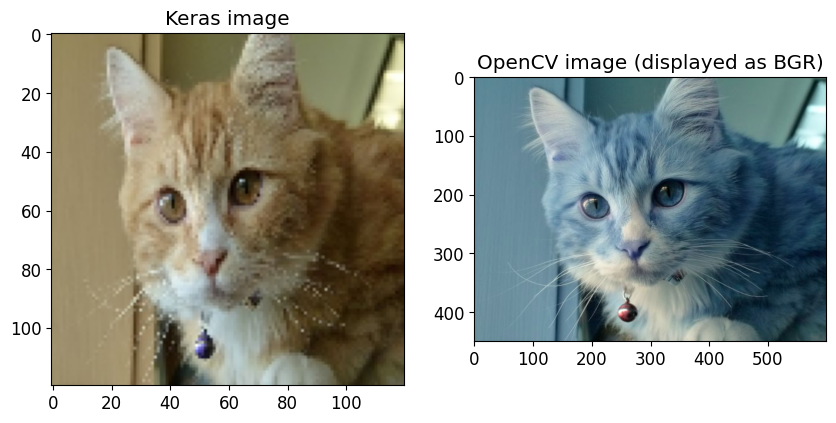

In [ ]:
# Range before preprocessing
print('np.min(img_data) :',np.min(img_data))
print('np.max(img_data) :',np.max(img_data))

# Range after preprocessing
print('np.min(img_preprocessed) :',np.min(img_preprocessed))
print('np.max(img_preprocessed) :',np.max(img_preprocessed))

# Shapes
print('img_preprocessed.shape :',img_preprocessed.shape)
print('mobilenet_features.shape :',mobilenet_features.shape)
print('img_preprocessed.flatten().shape :',img_preprocessed.flatten().shape)
print('mobilenet_features.flatten().shape :',mobilenet_features.flatten().shape)
print('dimensionality reduction :',img_preprocessed.flatten().shape[0]/mobilenet_features.flatten().shape[0])

# RGB or BGR?
import cv2
import matplotlib.pyplot as plt
img_opencv = cv2.imread(str(img_path))
plt.figure(figsize=(10,6))
plt.subplot(121); plt.imshow(img_data.squeeze()/255); plt.title('Keras image')
plt.subplot(122); plt.imshow(img_opencv); plt.title('OpenCV image (displayed as BGR)')

##Task 5: Feature maps
As we have seen above, a convolutional neural network consists of many layers. Each layer performs some mathematical operation on the output of the previous layer. The operations have names like ``Conv2D`` , ``BatchNormalization``, ``ReLU``, and ``DepthwiseConv2D``, which you will learn about during the course.

The output of a layer is referred to as a **feature map**.

Let's look at some feature maps produced by the first layer:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Feature map size: 60x60x32


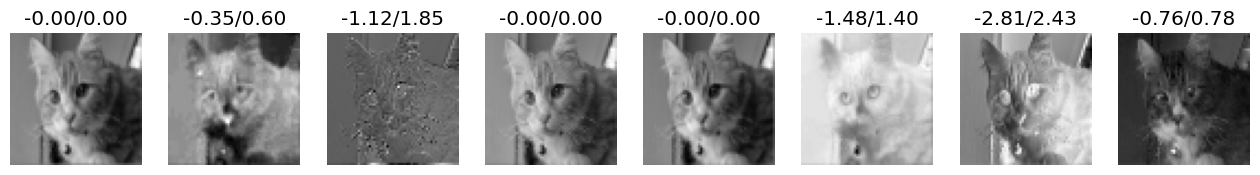

In [ ]:
from keras import Model

def show_feature_maps_from_layer(layer_name='conv1',img=img_preprocessed):
  dummy_model = Model(inputs=conv_base.input, outputs=conv_base.get_layer(layer_name).output)
  out = (dummy_model.predict(img)).squeeze()
  height = out.shape[0]
  width = out.shape[1]
  num_channels = out.shape[2]
  print(f'Feature map size: {height}x{width}x{num_channels}')

  plt.figure(figsize=(16,16))
  for i in range(8): # only display first 8 feature maps (channels)
    f = out[:,:,i]
    plt.subplot(1,8,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

# See conv_base.summary() for complete list of layer names
show_feature_maps_from_layer(layer_name='conv1')

Because this layer (``conv1``) is a convolution layer, each feature map results from applying a filter to the input image. As you can see, different filters highlight different features of the input image. The next layer in the network then takes these feature maps and transforms them somehow to extract new and more abstract features. In one of the later layers (``conv_dw_2``) we can still sort-of see the cat in the feature maps:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Feature map size: 30x30x64


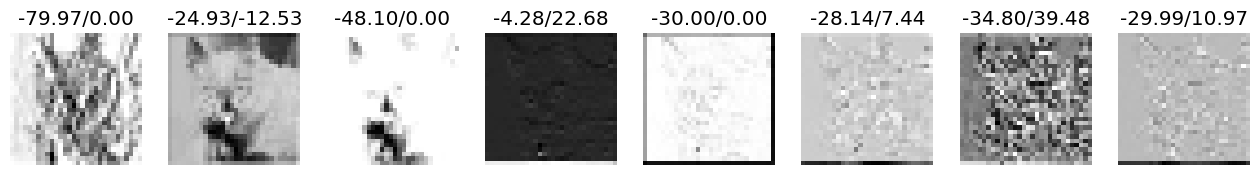

In [ ]:
show_feature_maps_from_layer(layer_name='conv_dw_2')

In the last feature map it is impossible for us to see that there was originally a cat in the input image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature map size: 3x3x1024


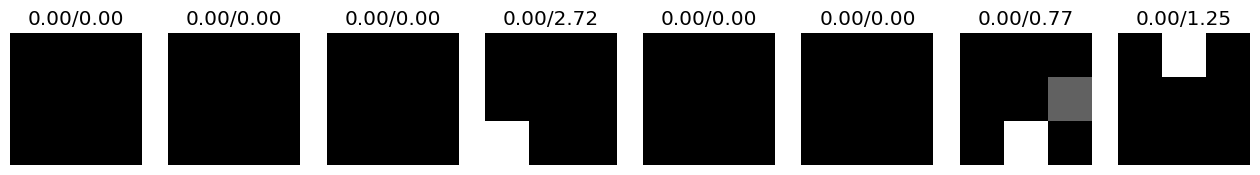

In [ ]:
show_feature_maps_from_layer(layer_name='conv_pw_13_relu')

### Question 5.1
1. Notice that the height and width of the feature maps become smaller and smaller as we move deeper into the network. Why do you think that is?
2. If the last feature map is only three pixels high and three pixels wide (shape is ``3x3x1024``), how can the neural network know that there is a cat in the image, i.e, where is that information encoded in the feature map?

##Task 6: How to use the image generator
Loading and preprocessing images is such a common task in deep learning that frameworks like Keras provide predefined tools for us that we can use.
In this task we will look at Keras' image data generator: https://keras.io/preprocessing/image/#imagedatagenerator-class. Simply put, the image generator is a tool that makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 8 images:


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True)

Found 241 images belonging to 3 classes.


**Note:** Check that the classes assigned by the generator are consistent with your class assignment:

In [ ]:
print('generator:',generator.class_indices)
print('your\'s:',dict((class_name,class_index) for class_index,class_name in enumerate(classes)))

generator: {'cat': 0, 'dog': 1, 'horse': 2}
your's: {'cat': 0, 'dog': 1, 'horse': 2}


Here is one way to generate a new batch:

In [ ]:
inputs, labels = generator.__getitem__(0)

### Questions 6.1
1. What is variable ``inputs``? (Hint: look at the shape)
2. What is variable ``labels``?
3. How does the image generator know where the images are stored?
4. How does the image generator know the class of each image?
5. What does shuffle mean?

### Answers
See code below answers.
1. The shape of ``inputs`` is 8x120x120x3. So this is a mini-batch of 8 images of size 120x120x3.
2. Variable ``labels`` has size 8x3. Each row is a one-hot encoded label: It is a vector of zeros everywhere, except at the index corresponding to the correct class.
3. First argument to the function ``flow_from_directory`` is a path to a directory containing the images. There should be a sub directory for each class.
4. By reading the name of the sub directory :-)
5. If shuffle is set to False, all images will be read in alpha-numeric order. This is usually not recommended, because it means that we will first load all cat images, then all dog images, etc. If we train our model on mini-batches, this implies that the first many batches will only contain cats, so if we are training a neural network, it will essentially learn nothing useful. We should have images from as many classes as possible in each batch.

In [ ]:
# Shapes
print('inputs.shape :',inputs.shape)
print('labels.shape :',labels.shape)
print('labels :\n',labels) # One-hot encoding

inputs.shape : (8, 120, 120, 3)
labels.shape : (8, 3)
labels :
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


As you learned in lecture 2 it is always a good idea to split the data into a training set and a validation set. Again, this is such a common task in deep learning that the image generator can do it for us:

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 195 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


### Questions 6.2
1. How does each of the two generators know if it should produce training or validation images?
2. What is the validation percentage in this example?

### Answers
1. Training or validation is determined by argument "subset", which can be either 'training' or validation'.
2. The validation percentage (i.e., the percentage of images that we keep aside for validation) is determined by argument "validation_split". It is 20% in this example, which is a commonly used value in practise.

## Task 7: Feature extraction
Our goal is to train a machine learning model to correctly classify images belonging to the chosen categories (cat, dog, horse). Today, we will be using KNN, which operates on vectors. Therefore, we have to convert our images into vectors.

We have two choices of features:

1. Raw pixel values
2. MobileNet features

Besides the features we will of course also need the labels (cat, dog, horse).

Let's create the datasets that we will be using:


In [ ]:
def extract_features(generator):
  generator.reset()
  raw_pixel_features_list = []
  mobilenet_features_list = []
  labels_list = []
  batch_index = 0
  while batch_index < generator.num_batches:
    # Load mini-batch
    raw_pixels, labels = generator.__getitem__(batch_index)

    # Run through MobileNet encoder
    mobilenet_features = conv_base.predict(raw_pixels) # This is where we apply the CNN

    # Vectorize images
    bs,h,w,c = raw_pixels.shape
    raw_pixels = np.reshape(raw_pixels,(bs,h*w*c)) # vectorize

    # Vectorize MobileNet features
    bs,h,w,c = mobilenet_features.shape
    mobilenet_features = np.reshape(mobilenet_features,(bs,h*w*c)) # vectorize

    # Convert one-hot encoding to class index
    labels = np.argmax(labels,axis=1)

    # Save in lists
    for i in range(bs):
      raw_pixel_features_list.append(raw_pixels[i])
      mobilenet_features_list.append(mobilenet_features[i])
      labels_list.append(labels[i])

    batch_index = batch_index + 1

  # Convert lists to numpy arrays
  raw_pixel_features = np.asarray(raw_pixel_features_list)
  mobilenet_features = np.asarray(mobilenet_features_list)
  labels = np.asarray(labels_list)

  return raw_pixel_features, mobilenet_features, labels

In [ ]:
train_features_raw, train_features_mobilenet, train_labels = extract_features(train_generator)
validation_features_raw, validation_features_mobilenet, validation_labels = extract_features(validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

Show the first 32 images of the validation data set:

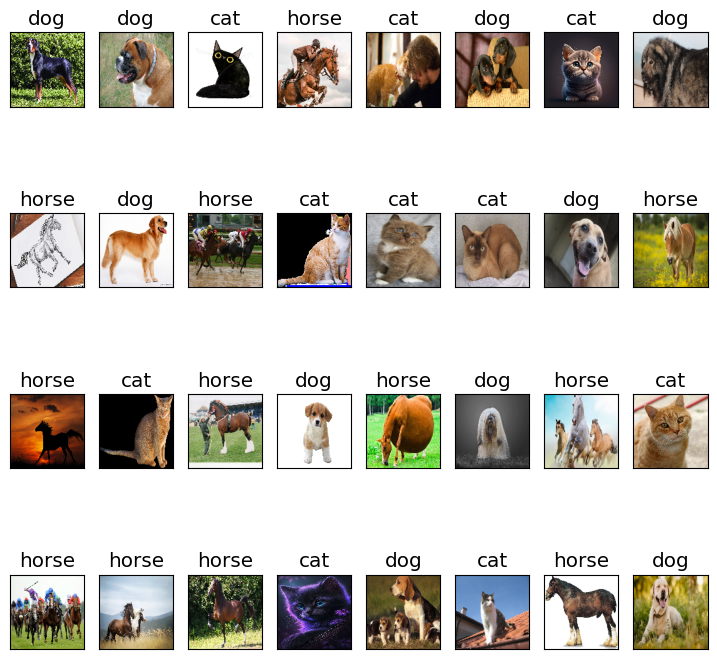

In [ ]:
def denormalize(input_img):
  '''
    input_img has intensities in range -1 to 1 (after Keras MobileNet preprocessing)
    output_img has intensities in range 0 to 1 (float)
  '''
  output_img = (input_img+1) / 2
  return output_img

def vec2img(img_as_vec,output_shape=(120,120,3)):
  '''
    img_as_vec is a vectorized color image
    output_shape is the desired output image shape
  '''
  img_as_array = np.reshape(img_as_vec,output_shape)
  return img_as_array

plt.figure(figsize=(9,9))
for i in range(32):
  # reshape feature vector into 120x120x3 array (image) and de-normalize intensities to range 0 to 1.
  img = vec2img(validation_features_raw[i,:])
  img = denormalize(img)
  plt.subplot(4,8,i+1)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.title(classes[int(validation_labels[i])])

**Sub-task:** Verify that the labels above are correct

### Questions 7.1
The image data has now been vectorized.
1. What is the shape of ``train_features_raw``?
2. What is the shape of ``train_features_mobilenet``?
3. What is the difference between ``train_features_raw`` and ``train_features_mobilenet``, i.e., what do they represent?
4. What is the shape of ``train_labels``?
5. How many training samples do we have, and how many validation samples?

### Answers
Note that my shapes may vary from yours.

1. The shape of ```train_features_raw``` is 195 x 43200. This means that we have 195 samples in our training set, and when using the raw pixels as the features the feature vectors are 43200-dimensional.
2. The shape of ```train_features_mobilenet``` is 195 x 9216. This means that we have 195 samples in our training set, and when using the mobilenet features, the feature vectors are 9216-dimensional.
3. ```train_features_raw``` represent raw pixels, ```train_features_mobilenet``` are features obtained by encoding the input image using MobileNet.
4. ```train_labels``` is just a vector of length 195. The i'th entry is an index corresponding to the correct class index of the i'th training sample.
5. 195 training samples and 46 validation samples.

In [ ]:
print('train_features_raw shape:',train_features_raw.shape)
print('train_features_mobilenet shape:',train_features_mobilenet.shape)
print('train_labels shape:',train_labels.shape)
print('validation_features_raw shape:',validation_features_raw.shape)
print('validation_features_mobilenet shape:',validation_features_mobilenet.shape)
print('validation_labels shape:',validation_labels.shape)

train_features_raw shape: (195, 43200)
train_features_mobilenet shape: (195, 9216)
train_labels shape: (195,)
validation_features_raw shape: (46, 43200)
validation_features_mobilenet shape: (46, 9216)
validation_labels shape: (46,)


##Task 8: Classify images using K-Nearest Neighbours (K-NN) classifier
Your task is to train a K-NN classifier on the training set, and evaluate the performace on the validation set by calculating the accuracy (and remember to calculate the accuracy on the validation set, not the training set!).

First solve the task using the raw pixels as features:

```
# Training set
train_features_raw, train_labels

# Validation set
validation_features_raw, validation_labels
```

Then solve the same task using the MobileNet features:

```
# Training set
train_features_mobilenet, train_labels

# Validation set
validation_features_mobilenet, validation_labels
```

Compare the results and explain the difference.

You are on your own here, but **you don't have to implement K-NN yourself**. I suggest you use [scikit-learn](https://scikit-learn.org) (and Google).

### Solution - raw pixels

In [ ]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
from sklearn import neighbors

# Train on training set with k = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree').fit(train_features_raw,train_labels)

# Predict on validation set
pred = clf.predict(validation_features_raw)

# Accuracy
num_correct = len(np.where(pred==validation_labels)[0])
num_total = len(validation_labels)
accuracy = num_correct / num_total
print(accuracy)

0.43478260869565216


I got 43% accuracy. So just slightly better than guessing at random (33%)...

### Solution - MobileNet features

In [ ]:
# Train on training set with k = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree').fit(train_features_mobilenet,train_labels)

# Predict on validation set
pred = clf.predict(validation_features_mobilenet)

# Accuracy
num_correct = len(np.where(pred==validation_labels)[0])
num_total = len(validation_labels)
accuracy = num_correct / num_total
print(accuracy)

0.7608695652173914


I got 76%, which is quite an improvement over 43%.

**Comparison:** If everything went as planned, you should be able to conclude that the accuracy of the K-NN classifier is significantly higher when using the neural networks features compared to when using the raw pixel values as features. This is becuase the MobileNet has already been pre-trained, i.e., it has learned features that are useful for classifying 1000 different object categories. In almost any scenario you can think of, MobileNet's feature representation will be better than using the raw pixels.

### Comments
So what we have learned so far is that images of the same class tend to group closer together when using MobileNet's feature representation, but not so much when using the raw intensities. This confirms that using the raw pixels as features is in general not a good idea.

The reason that MobileNet's feature representation works better is because the network has learned to map images onto a manifold. A manifold is kind of like a low-dimensional surface that exists in a high-dimensional space. For instance if images of faces were to be mapped into a 4D manifold, the first axis on the manifold could represent gender, and the others could represent age, view angle, and eye color. You can read more about manifold learning in chapter 5.11.3 of the book.

The underlying hypothesis of using K-NN to classifiy images using MobileNet features is that objects that are similar will map to the approximate same location on some manifold.

##Task 9: Transfer learning


Putting your own K-NN classifier on top of a pre-trained CNN is not really optimal. Why? Because, while the features of the convolutional base are better than using raw pixel values, they are not guaranteed to 100% optimal for your specific task. So, a better solution is to attach a second neural network on top of the convolutional base, and train both the classifier *and* the convolutional base at the same time. This is called **transfer learning**. The extra neural network that is put on top of our encoder is often referred to as a "decoder" or a "classification head".

Recall that CNNs like AlexNet and MobileNet have been trained on ImageNet, which contains 1000 classes. If you download Keras' pre-trained models *including the top layers* (i.e., the decoder), the top layers are in fact the classifier that we want to replace. Let's verify this:

In [ ]:
mobilenet_full = MobileNet(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))
mobilenet_full.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

###Questions 9.1
Inspect the printout above.
1.  Can you identify the convolutional base of this network? (Compare to the ```conv_base``` model we used earlier.)
2. All layers beyond the convolutional base represent the classifier (or decoder). How many classes are there?
3. So what is the size of the output of the model?
4. Can you guess how we should interpret the output of model?
5. The input size must be 224 by 224 pixels (you can verify for yourself). Why do you think that is?

### Answers
1. The convolutional base consists of all layers up and until conv_pw_13_relu, which produces an output of size 7x7x1024. This is then converted into a 1024-dimensional vector using global average pooling. This suggests that the network is just averaging over the entire 7x7 grid.
2. There are 1000 classes (because there are 1000 classes in the ImageNet database)
3. So the output of the network is a 1000-dimensional vector - one probability per class.
4. The i'th element of the output vector is *the probability* that the input image belongs to the i'th class, *as predicted by the network*.
5. A neural network is essentially a bunch of matrix-vector multiplications (plus a few more operations...). If the sizes of the matrices and vectors do not match, the math doesn't work. This is the most likely explanation, but in fact changing the input image size shouldn't cause problems here because global_average_pooling2d_1 effectively removes the 7x7 grid, which is where we could get into trouble with matrix/vector size mismatches... I guess changing the input size just doesn't work in practise, in the sense that the math works, but the network doesn't perform that well (i.e., accuracy is low).

So, how do we modify and re-train MobileNet to work on our own data? First of all, we don't want to train CNNs from scratch, since this could take days. Secondly, we need to modify the network architecture to output three class labels (cat, dog, horse) instead of 1000.

The main hypothesis underlying transfer learning is that the network weights learned in the convolutional layers (i.e., the *encoder*) are generic and need little or no fine-tuning to work on other data sets or tasks. So in practice, we just need to replace and re-train the last layers (i.e., the *decoder*) of a pre-trained network.

So let's take our convolutional base (encoder) and put a simple neural network classifier (decoder) on top of it. Your task is to figure out what the value of variable N should be.

### Solution

In [ ]:
N = 3

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Note that the weights of the new dense layers are initialized with random values. So we need to train the dense layers on our dataset to make it work.

###Questions 9.2
1. What should N be in the above code block?
2. Re-run the code block with the correct N.
3. What does GlobalAveragePooling2D do?

Hint: You can print all layers and print properties like name, type and input shape:

In [ ]:
for i,layer in enumerate(model.layers):
  layer_name = layer.name
  layer_type = layer.__class__.__name__

  try:
    input_shape = layer.input.shape
    print(f"Layer {i} has name {layer_name} and type {layer_type}, and its input shape is {input_shape}")
  except Exception as e:
    pass

# Or use the summary function:
model.summary()

Layer 1 has name conv1 and type Conv2D, and its input shape is (None, 120, 120, 3)
Layer 2 has name conv1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 32)
Layer 3 has name conv1_relu and type ReLU, and its input shape is (None, 60, 60, 32)
Layer 4 has name conv_dw_1 and type DepthwiseConv2D, and its input shape is (None, 60, 60, 32)
Layer 5 has name conv_dw_1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 32)
Layer 6 has name conv_dw_1_relu and type ReLU, and its input shape is (None, 60, 60, 32)
Layer 7 has name conv_pw_1 and type Conv2D, and its input shape is (None, 60, 60, 32)
Layer 8 has name conv_pw_1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 64)
Layer 9 has name conv_pw_1_relu and type ReLU, and its input shape is (None, 60, 60, 64)
Layer 10 has name conv_pad_2 and type ZeroPadding2D, and its input shape is (None, 60, 60, 64)
Layer 11 has name conv_dw_2 and type DepthwiseConv2D, and its input shape is (N

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 60, 60, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 60, 60, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 60, 60, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 60, 60, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 60, 60, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 30, 30, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 30, 30, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 30, 30, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 30, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 30, 30, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 30, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 30, 30, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,281,539 (16.33 MB)

 Trainable params: 4,259,651 (16.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Answers
1. N is the number of classes. The network outputs a vector with one entry per class, corresponding to the class probability.
2. Done
3. global_average_pooling2d_1 gets rid of the 3x3 grid that is produced by the last layer of the convolutional base. So the 3x3x1024 array created by that layer is converted into a 1024 dimensional vector by averaging over grid cells. Why is this necessary? Because the next layer is a dense layer, which is a matrix-vector multiplication that expects a 1024-dimensional input vector.

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


We are now ready to start training the model using
- Adam optimizer
- loss function will be categorical cross entropy
- evaluation metric will be accuracy


In [ ]:
from tensorflow.keras import optimizers

# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)
#sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step - accuracy: 0.5228 - loss: 1.7808 - val_accuracy: 0.8250 - val_loss: 0.6682
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7500 - loss: 0.4821

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7500 - loss: 0.4821 - val_accuracy: 0.6667 - val_loss: 0.8787
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - accuracy: 0.8242 - loss: 0.3238 - val_accuracy: 0.7500 - val_loss: 0.8934
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0572 - val_accuracy: 0.8333 - val_loss: 0.7200
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.8924 - loss: 0.3220 - val_accuracy: 0.7500 - val_loss: 0.8959
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0316 - val_accuracy: 1.0000 - val_loss: 0.0629
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - accuracy: 0.9091 - loss: 0.2579 - val_accuracy: 0.8250 - val_loss: 0.5894
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0924 - val_accuracy: 0.5000 - val_loss: 2.1052
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.8813 - loss: 0.3814 - val_accuracy: 0.7750 - val_

###Questions 9.3
Look at the outputs of the training.

1. What is the difference between 'loss' and 'val_loss'?
2. What is the difference between 'accuracy' and 'val_accuracy'?
3. Do they behave the same, or do they behave differently? Try to explain what you see.

###Answers:
1. The 'loss' is the networks prediction error on the training set. This is essentially the metric that we are trying to minimize during training. If everything is set up correctly (and by that I mean hyperparameters such as learning rate), the training loss should decrease over time. It can fluctuate, however, and that is because it is not evaluated on the entire training data set, but rather on small mini-batches. This can course some random variation. The 'val_loss' is the loss on the validatin data set, i.e., images not seen during training. This should ideally also decrease over time, but it will almost never be as low as the training loss. *The degree to which the validation loss decreases says something about how well the model generalises to unseen data*.
2. This is the evaluation metric - it is not used for optimization/training. It only serves as a human interpretable measure of how well the model performs on the training set and the validation set. Again, we want a high accuracy on the validation set (=unseen data).
3. The training loss always decreases, and training accuracy always increases (if things are set up correctly). The validation loss/accuracy follow the same trend to begin with, but at some point we should expect them to stagnate. **CAUTION**: If the validation loss starts to increase (and accuracy drops), then it is a strong indication that your model has started **overfitting**. What does that mean? It simply means that the model has started remembering the training data set instead of learning useful features that generalize beyond the training data set. Think of the example from lecture 2 with the dog Loui. We don't want our model to remember images of Loui; we want our model to learn which features that distinguish the Loui-the-beaggle from other beaggles.

We can plot the accuracy as a function of the epoch number (and epoch is when all training have been processe exactly once). Notice how the training accuracy increases in the beginning and then stagnates. This is normal training behavior. The validation accuracy stays farily constant, meaning that training the model further (for more epochs) would most likely *not* improve the performance.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


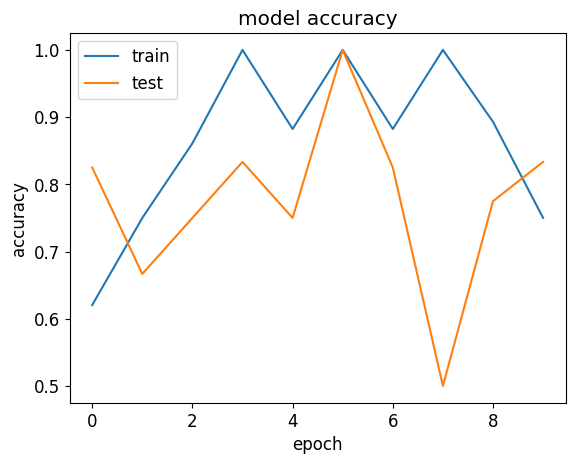

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

For the loss, we observe a similar pattern, except that the loss increases over time (which it should)

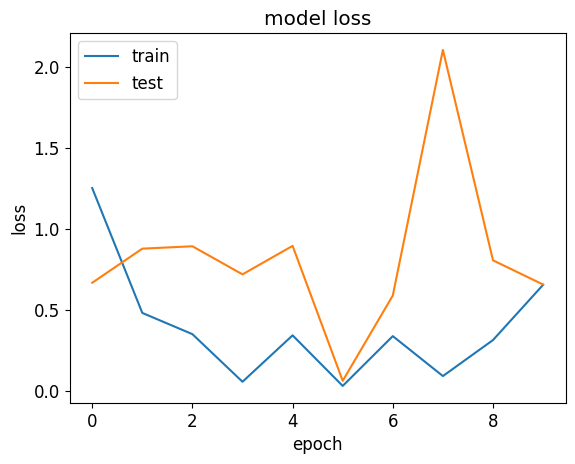

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Task 10: Deploying the model
Here is how to deploy the model and integrate with OpenCV.

File path: /content/gdrive/My Drive/data/cat/b2e1c03d-e4b9-44d6-a836-75893862de34.jpg!s1


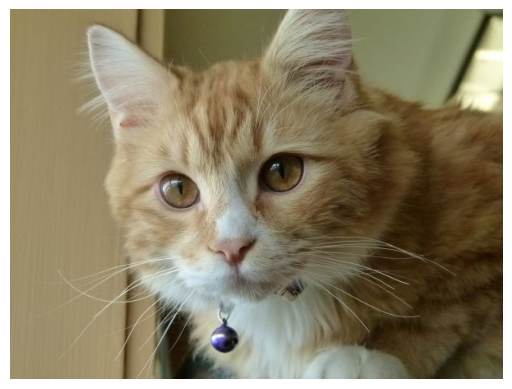

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Remember to convert to RGB
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img);
plt.axis('off');

Now, make sure that the image shape and the pixel intensity range is as expected by the network (required shape = `1x120x120x3` and intensity range from -1 to 1):

In [ ]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape,img.min(),img.max())

(1, 120, 120, 3) -1.0 1.0


Run the image through the network:

In [ ]:
class_probabilities = model.predict(img)[0]
print(class_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[9.9802929e-01 4.8709969e-04 1.4835979e-03]


In [ ]:
# pick class with highest probability
class_index = (-class_probabilities).argsort()[0]
print(f'The image displays a {classes[class_index]}!')

The image displays a cat!


##Task 11: Image retrieval (optional task)
Implement an image search engine (this is also called image retrieval). Use MobileNet features, and if you have time do a comparison with raw pixel features.

The search engine could work like this:

1. Given an input image from the validation set, pre-process it and feed it through MobileNet to calculate the feature vector.
2. Then perform a K-NN search with K=10 against the feature vectors in the training set.
3. Then return the corresponding 10 closest images.

In principle we should preprocess the input image like this:
```
img = image.load_img(some_image_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data)
```
But it is okay to cheat and use the image data that have already been preprocessed and run through MobileNet.

**Question:** What kind of search results do you expect to see when using MobileNet features vs.**bold text** using raw pixel features?

### Solution

In [ ]:
# Train K-NN classifier on training features
def train_model(train_features,n_neighbors=10):
  nbrs = neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(train_features)
  return nbrs

# Train models
nrbs_mobilenet = train_model(train_features_mobilenet)
nrbs_raw_pixels = train_model(train_features_raw)

Query image


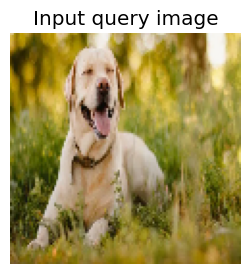

Image retrieval using MobileNet features:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
10 closest matches


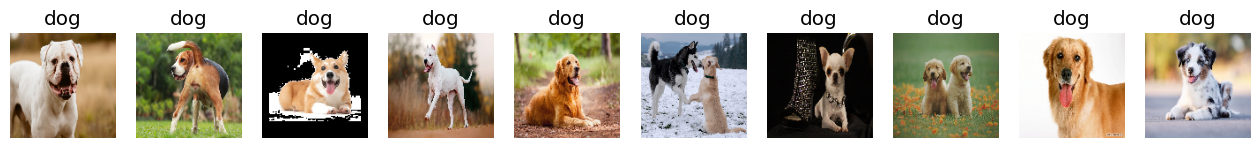


Image retrieval using raw pixels:
10 closest matches


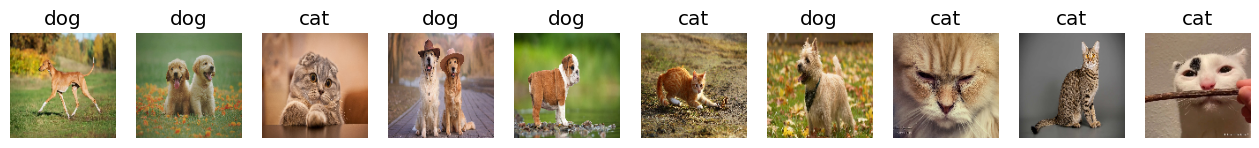

In [ ]:
def search_and_display(input_features,nrbs):

  # Get indices of 10 nearest neighbours (+ distances)
  distances, indices = nrbs.kneighbors(input_features)

  print('10 closest matches')
  plt.figure(figsize=(16,8))
  for i in range(10):
    plt.subplot(1,10,i+1)
    im = (np.reshape(train_features_raw[indices[0][i],:],(120,120,3)) + 1) / 2
    plt.imshow(im)
    plt.title(classes[train_labels[indices[0][i]]])
    plt.axis('off')

  plt.show()

# Pick random validation image (already preprocessed)
num_validation_images = validation_features_raw.shape[0]
ix = np.random.randint(low=0,high=num_validation_images)
img_as_vec = validation_features_raw[ix,:]
img_preprocessed = vec2img(img_as_vec,output_shape=(120,120,3))
img_display = denormalize(img_preprocessed) # de-normalize intensities
img_preprocessed = np.expand_dims(img_preprocessed,axis=0) # add batch dimension (required by model)

# Display query image
print('Query image')
plt.figure(figsize=(3,3))
plt.imshow(img_display) # Scale image to rage 0 to 1
plt.axis('off')
plt.title('Input query image')
plt.show()

###########################
# 1) MobileNet feature
print('Image retrieval using MobileNet features:')
X = conv_base.predict(img_preprocessed)
X = np.reshape(X,(1,3*3*1024)) # Vectorize
search_and_display(X,nrbs_mobilenet)

###########################
# 2) Raw image
print('')
print('Image retrieval using raw pixels:')
X = img_as_vec
X = np.reshape(X,(1,120*120*3)) # Vectorize
search_and_display(X,nrbs_raw_pixels)


### Comments
When performing image search using MobileNet features we get images that are semantically similar to the input image (i.e., same class label).

When using the raw pixels as features, we get images that are similar in terms of pixel values. The images are not always semantically similar to the input image.

##Task 12: K-means clustering (optional task)
As stated above, the underlying hypothesis of using K-NN to classifiy images using MobileNet features is that *objects that are similar will map to the approximate same location on some manifold.*

Here we will perform K-means clustering and verify that this is in fact the case. For the record, recall that the K-means method is an *unsupervised learning method*, so it doesn't know anything about the class labels.

**Your task** is to perform K-means clustering twice on your training dataset: first using the raw intensity features (``train_features_raw``), then using the MobileNet features (``train_features_mobilenet``). Use as many clusters as you have classes, which is 3 if you also used cat, dog, and horse.

For each cluster, print the class labels (cat, dog, horse) or the class indices (0, 1, 2) of all images in that cluster. Explain what you observe and compare between MobileNet features and raw pixel intensities.

**Note** that we wont be needing the validation set in this task. Why? Because K-means is an unsupervised learning method often used to perform exploratory data analysis. Here we are pretending that we dont know the true labels. We are just interested in seeing if the image data form clusters or not.

Again, **you don't have to implement K-means clustering from scratch**. You can use scikit-learn (and Google).



### Solution: Raw pixels
Look at the labels of the samples in each cluster printed below. They look pretty random. This means that the clusters found by K-means using raw pixel values are not related to the object categories.

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(train_features_raw)

pred = kmeans.predict(train_features_raw)

for c in range(3):
  ix = np.where(pred==c)[0]
  print(f'true labels of data in cluster {c}:')
  print(train_labels[ix])

print('How to interpret the numbers:',generator.class_indices)

true labels of data in cluster 0:
[0 1 1 2 2 0 0 1 0 1 2 0 0 2 1 1 2 2 1 0 0 0 2 0 1 2 0 2 1 0 2 0 2 2 0 0 1 1 2 0 2 2 2 0 2 1 1 2 2 2]
true labels of data in cluster 1:
[1 0 2 1 0 0 1 2 1 1 0 1 2 0 2 1 0 1 2 1 2 1 1 1 1 0 2 0 2 1 0 0 2 0 0 0 1 0 0 0 2 2 2 0 2 0 1 1 0 2 1 0 0 1 2 1 2 1 0 1 0 0 0 0 2 0 0 1 0 1 1 2 2 2 0 1 2 2 1 1 2 1 1 1 1 2 1 2 2 0 1 0 2 0]
true labels of data in cluster 2:
[0 0 2 1 0 1 2 1 1 2 2 2 2 1 1 1 1 0 0 2 0 0 1 1 0 0 1 0 1 2 2 0 1 0 0 2 1 0 2 0 0 2 2 2 2 1 2 1 2 0 1]
How to interpret the numbers: {'cat': 0, 'dog': 1, 'horse': 2}


### Solution: Network features
Look at the labels of the samples in each cluster printed below. We observe that the labels of the samples in each cluster are pretty similar. This means that K-means, although it is an unsupervised method and knows nothing about the true labels, is at able to partially separate the classes in our dataset.

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(train_features_mobilenet)

pred = kmeans.predict(train_features_mobilenet)

for c in range(3):
  ix = np.where(pred==c)[0]
  print(f'true labels of data in cluster {c}:')
  print(train_labels[ix])

print('How to interpret the numbers:',generator.class_indices)

true labels of data in cluster 0:
[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0]
true labels of data in cluster 1:
[1 2 2 1 2 1 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 1 2 2 1 2 2 2 1 1 1 2 2 2 2]
true labels of data in cluster 2:
[1 0 2 1 1 1 2 2 1 1 0 1 2 1 1 1 1 1 2 0 2 1 1 1 1 1 1 0 1 1 2 2 2 1 0 1 1 1 2 2 1 1 2 2 1 0 0 1 1 1 1 2 2 0 1 1 1 2 2 2 2 2 2 2 1 2 2 2 1 2 1 1 2 1 2 1 2]
How to interpret the numbers: {'cat': 0, 'dog': 1, 'horse': 2}


##Task 13: Visualising high-dimensional datasets using PCA and t-SNE in Python
Simply speaking, t-SNE is a dimensionality reduction technique that maps N-dimensionalal data to, say, 2D, where points that are close in N-dimensional space are close in the 2D space.

Thus, we can use t-SNE to visualize our high-dimensional image dataset in 2D. If we colorize the data points according to their class label, we can see if our choice of feature representation (i.e., raw pixel values or MobileNet features) is useful for separating the classes.

So lets do that for both choices of features.

Read more here: https://builtin.com/data-science/tsne-python

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

def run_tsne(features,labels,classes=classes):
  X = features
  y = labels

  feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
  df = pd.DataFrame(X,columns=feat_cols)
  df['y'] = y
  df['label'] = df['y'].apply(lambda i: str(i))
  X, y = None, None
  print('Size of the dataframe: {}'.format(df.shape))

  rndperm = np.random.permutation(df.shape[0])

  N = 10000
  df_subset = df.loc[rndperm[:N],:].copy()
  data_subset = df_subset[feat_cols].values
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(data_subset)
  df_subset['pca-one'] = pca_result[:,0]
  df_subset['pca-two'] = pca_result[:,1]
  df_subset['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(data_subset)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  df_subset['tsne-2d-one'] = tsne_results[:,0]
  df_subset['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(8,8))
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette(n_colors=len(classes)),
      data=df_subset,
      legend="full"
  )

t-SNE allows us to visually verify that when using the raw pixels as features, the data points do not form clusters corresponding to the classes:

Size of the dataframe: (195, 43202)
Explained variation per principal component: [0.32095924 0.07371098 0.05666048]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 195 samples in 0.085s...
[t-SNE] Computed neighbors for 195 samples in 0.251s...
[t-SNE] Computed conditional probabilities for sample 195 / 195
[t-SNE] Mean sigma: 49.382148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.028603
[t-SNE] KL divergence after 300 iterations: 0.961880
t-SNE done! Time elapsed: 1.5607178211212158 seconds


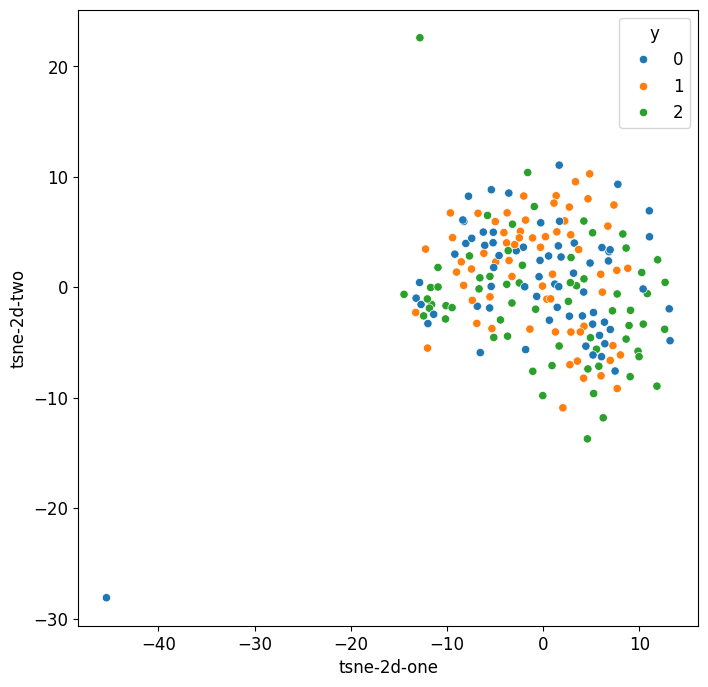

In [ ]:
run_tsne(train_features_raw,train_labels)

Figure above: Raw pixels mapped to 2D using t-SNE. The data points do not form clusters corresponding to the classes (blue, orange, green dots).

Now, let's repeat the t-SNE analysis, but this time using the MobileNet features is input:

Size of the dataframe: (195, 9218)
Explained variation per principal component: [0.05696144 0.03164813 0.02737432]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 195 samples in 0.019s...
[t-SNE] Computed neighbors for 195 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 195 / 195
[t-SNE] Mean sigma: 69.152972
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.790222
[t-SNE] KL divergence after 300 iterations: 0.995474
t-SNE done! Time elapsed: 0.9384043216705322 seconds


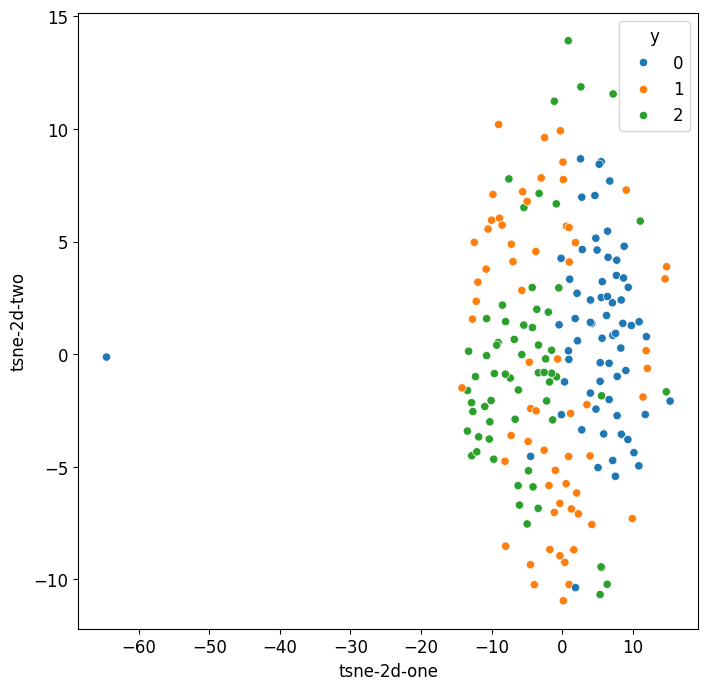

In [ ]:
run_tsne(train_features_mobilenet,train_labels)

Figure above: Now, we see at least some clustering corresponding to the classes.

This - again - tells us that the MobileNet (or CNN) features are better at separatin the classes than the raw pixel features.

##Ideas for further work
1. In the above example we have not optimized the pre-trained weights of the convolutional base (i.e., the encoder). To improve performance further you could enable training in all layers (including the convolutoinal base) and re-train the network. This is called *fine-tuning*.
2. Another way to improve model performance is by *data augmentation*. Have a look [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to see what kind of augmentation is possible. Why do you think data augmentation helps improve the performance of your model?

### Solutions:

1. To enable training of all layers, run the code below. Then re-train the model as above.

In [ ]:
for layer in model.layers[:num_base_layers]:
    layer.trainable=True

2. See examples of data augmentation [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). To solve the task, replace the training data generator with the one below and repeat training.

File path: /content/gdrive/My Drive/data/cat/b2e1c03d-e4b9-44d6-a836-75893862de34.jpg!s1
File path: /content/gdrive/My Drive/data/cat/b2e1c03d-e4b9-44d6-a836-75893862de34.jpg!s1


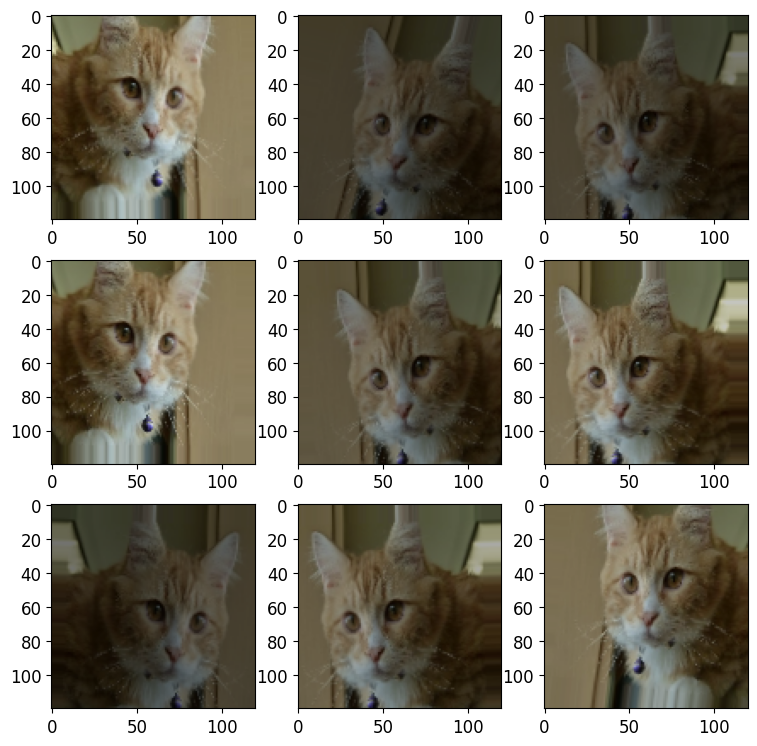

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-10,10],
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             rotation_range=20,
                             brightness_range=[0.4,1.0])
# prepare iterator
it = datagen.flow(img_data, batch_size=1)

plt.figure(figsize=(9,9))
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.__getitem__(0)
	# convert to unsigned integers for viewing
	img = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(img)
# show the figure
plt.show()

##Exporting to TensorFlow JS and hosting a web service on GitHub
If you wanted to, you could in principle deploy your model and make a nice web service like this one:
https://klaverhenrik.github.io/transferlearning/. The webpage is hosted on GitHub using [GitHub Pages](https://pages.github.com/).